<a href="https://colab.research.google.com/github/ShounakDas101/AIML_Hari/blob/main/ML4SCI_BinaryClassificationCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
import os
import h5py
import math
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
from torch.utils.data import Dataset, random_split, DataLoader
from torchvision import transforms
import torch.optim as optim

import matplotlib.pyplot as plt

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)

Device cpu


In [ ]:
DATA_DIR='./data'
'''
IMAGE_SIZE = 32 # W=32 H=32
NUM_CHANNELS = 2 # R G B then it should be 3
PATCH_SIZE = 4 # W_patch=4 H_patch=4
NUM_PATCHES = (IMAGE_SIZE//PATCH_SIZE)*(IMAGE_SIZE//PATCH_SIZE) # = 64
NUM_HEADS = 8  # enbedding dim should be divisible by no of heads
EMBBEDING_DIM = PATCH_SIZE*PATCH_SIZE*NUM_CHANNELS  #NUM_PATCHNELS
MLP_SIZE = 128
NUM_LAYERS = 8
'''
NUM_CLASSES = 2
NUM_WORKERS = 8
BATCH_SIZE = 256
EPOCHS = 40
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-1

In [ ]:
# clearing cuda cache memory
import gc
torch.cuda.empty_cache()
gc.collect()

0

In [ ]:
import os

# Specify the path to the file in your Google Drive
file_path = 'SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5'
# CHECKPOINT_PATH = '/content/drive/MyDrive/CHECKPOINTS'

# Check if the file exists
if os.path.exists(file_path):
    print(f"The file '{file_path}' exists.")
else:
    print(f"The file '{file_path}' does not exist.")

The file 'SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5' exists.


In [ ]:
import h5py

def find_keys(hdf5_obj, path='/'):
    """Recursively find keys in an HDF5 file."""
    keys = []
    for key in hdf5_obj[path].keys():
        full_path = f"{path}/{key}"
        keys.append(full_path)
        if isinstance(hdf5_obj[full_path], h5py.Group):
            keys.extend(find_keys(hdf5_obj, full_path))
    return keys

# Open the HDF5 file
file_path = 'SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5'  # Replace with your actual file path
with h5py.File(file_path, 'r') as hdf5_file:
    # Find keys starting from the root
    all_keys = find_keys(hdf5_file)

# Print the found keys
for key in all_keys:
    print(key)

//X
//y


In [ ]:
# import dataset

# importing electron dataset and seperating images and labels
electron_dataset = h5py.File("SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5","r")
electron_imgs=np.array(electron_dataset["X"])
electron_labels=np.array(electron_dataset["y"],dtype=np.int64)

# importing photon dataset and seperating images and labels
photon_dataset = h5py.File("SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5","r")
photon_imgs=np.array(photon_dataset["X"])
photon_labels=np.array(photon_dataset["y"],dtype=np.int64)

In [ ]:
print(electron_imgs.shape)
print(electron_imgs.dtype)
print(electron_labels)
print(photon_imgs.shape)
print(photon_labels)

(249000, 32, 32, 2)
float32
[1 1 1 ... 1 1 1]
(249000, 32, 32, 2)
[0 0 0 ... 0 0 0]


In [ ]:
# concatenate electron and photon images/labels
img_arrs = torch.Tensor(np.vstack((photon_imgs,electron_imgs)))
labels = torch.Tensor(np.hstack((photon_labels,electron_labels))).to(torch.int64)
print(img_arrs.shape)
img_arrs = img_arrs.permute(0,3,1,2)
print(img_arrs.shape)

torch.Size([498000, 32, 32, 2])
torch.Size([498000, 2, 32, 32])


In [ ]:
del electron_imgs,photon_imgs,electron_labels,photon_labels

In [ ]:
from torch.utils.data import Dataset, DataLoader, random_split

class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data[:,:,4:-4,4:-4]
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = {'image': self.data[idx], 'label': self.labels[idx]}
        return sample

In [ ]:
# Assuming img_arrs and labels are already defined
custom_dataset = CustomDataset(img_arrs, labels)

# Split the dataset into training, validation, and test sets
train_size = int(0.7 * len(custom_dataset))
valid_size = int(0.2 * len(custom_dataset))
test_size = len(custom_dataset) - train_size - valid_size
train_dataset, valid_dataset, test_dataset = random_split(custom_dataset, [train_size, valid_size, test_size])
print(len(valid_dataset)+len(test_dataset)+len(train_dataset))

498000


transforms should be used here before data loader generation

In [ ]:
# Create DataLoaders for training, validation, and test sets
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                                           num_workers=NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                                           num_workers=NUM_WORKERS, pin_memory=True)
test_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False,
                                          num_workers=NUM_WORKERS, pin_memory=True)



Step 1 Tasks:

1- turn an image into patches

2- flatten the patch feature maps into a single dimension

3- Convert the output into Desried output (flattened 2D patches): (196, 768) -> N×(P2⋅C) #Current shape: (1, 768, 196)


In [ ]:
# next(iter(...)) catches the first batch of the data loader
# If shuffle is True, this will return a different batch every time we run this cell
# For iterating over the whole dataset, we can simple use "for batch in data_loader: ..."
data_inputs = next(iter(train_loader))

# The shape of the outputs are [batch_size, d_1,...,d_N] where d_1,...,d_N are the
# dimensions of the data point returned from the dataset class
print("Data inputs", data_inputs['image'].shape, "\n")
# print("Full",data_inputs)

Data inputs torch.Size([256, 2, 24, 24]) 



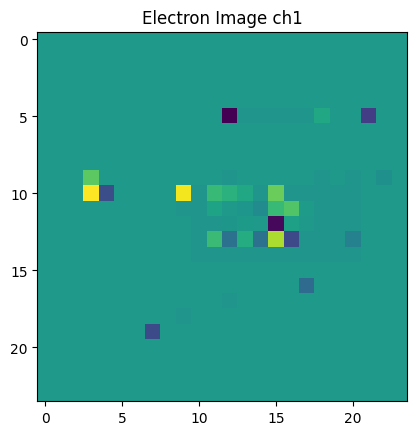

In [ ]:
plt.imshow(data_inputs['image'][0,1:2,:,:].permute(1,2,0))  # Assuming it's a 2-channel image; adjust if neededcmap='gray'
plt.title('Electron Image ch1')
plt.show()

In [ ]:
my_conv1 = nn.Conv2d(in_channels=2, out_channels=32, kernel_size=3, padding=1)
output=my_conv1((data_inputs['image']))
print(output.shape)
relu = nn.ReLU()
output=output.view(BATCH_SIZE,-1)
print(output.shape[0],output.shape[1])
fc = nn.Linear(output.shape[1],2)
fc(output)

torch.Size([256, 32, 24, 24])
256 18432


tensor([[-5.5154e-02, -1.2803e-01],
        [-5.2103e-02, -1.3500e-01],
        [ 7.2689e-03, -1.3097e-01],
        [-6.0871e-02, -1.3446e-01],
        [-3.1944e-02, -1.3867e-01],
        [-1.7648e-02, -1.1536e-01],
        [-4.8125e-02, -1.2411e-01],
        [-5.9432e-02, -1.0735e-01],
        [ 1.6285e-03, -1.7235e-01],
        [-5.8095e-03, -1.3022e-01],
        [-5.8623e-02, -1.2938e-01],
        [-5.3715e-02, -1.1010e-01],
        [-4.5587e-02, -1.1092e-01],
        [-2.6330e-02, -1.2500e-01],
        [-5.6937e-02, -1.3133e-01],
        [-9.0975e-02, -1.2946e-01],
        [-4.6858e-02, -1.2257e-01],
        [-5.5542e-02, -1.2132e-01],
        [-2.7580e-02, -1.3476e-01],
        [-2.0765e-02, -1.1341e-01],
        [-5.0439e-02, -1.1576e-01],
        [-4.7667e-02, -1.4551e-01],
        [-3.7667e-02, -1.1841e-01],
        [-3.0951e-02, -1.3134e-01],
        [-4.6983e-02, -1.2617e-01],
        [-2.6739e-02, -1.4490e-01],
        [-3.6488e-02, -1.1606e-01],
        [-1.9706e-02, -1.062

In [ ]:

class MyModel(nn.Module):

    def __init__(self, num_classes=1,dropout_rate=.2):
        super().__init__()
        self.my_conv1 = nn.Conv2d(in_channels=2, out_channels=8, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_rate)

        self.Linear1=nn.Linear(24*24*8,24*24*1)
        self.Linear2=nn.Linear(24*24*1,24*8)
        self.Linear3=nn.Linear(24*8,4)

        self.Linear=nn.Linear(4,num_classes)

    def forward(self, x):
        x['image'] =self.my_conv1(x['image'])
        x['image'] =self.relu(x['image'])
        x['image'] =self.dropout(x['image'])
        #x['image'] =self.my_conv1(x['image'])
        #x['image'] =self.relu(x['image'])
        x['image'] =x['image'].view(BATCH_SIZE,-1)

        x['image'] =self.Linear1(x['image'])
        x['image'] =self.relu(x['image'])
        x['image'] =self.dropout(x['image'])
        x['image'] =self.Linear2(x['image'])
        x['image'] =self.relu(x['image'])
        x['image'] =self.dropout(x['image'])
        x['image'] =self.Linear3(x['image'])
        x['image'] =self.relu(x['image'])
        x['image'] =self.dropout(x['image'])
        x['image'] =self.Linear(x['image'])
        return x['image']




In [ ]:
model = MyModel(num_classes=1)
model.to(device)
print(model)

MyModel(
  (my_conv1): Conv2d(2, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (Linear1): Linear(in_features=4608, out_features=576, bias=True)
  (Linear2): Linear(in_features=576, out_features=48, bias=True)
  (Linear3): Linear(in_features=48, out_features=4, bias=True)
  (Linear): Linear(in_features=4, out_features=1, bias=True)
)


In [ ]:
def eval_model(model, data_loader):
    model.eval() # Set model to eval mode
    true_preds, num_preds = 0., 0.

    with torch.no_grad(): # Deactivate gradients for the following code
        for data_inputs in data_loader:
            is_last_batch = data_inputs['image'].shape[0] < BATCH_SIZE
            if is_last_batch:
                break

            ## Step 1: Move input data to device (only strictly necessary if we use GPU)
            data_inputs['image'] = data_inputs['image'].to(device)
            data_inputs['label'] = data_inputs['label'].to(device)
            preds = model(data_inputs)
            preds = preds.squeeze(dim=1)
            preds = torch.sigmoid(preds) # Sigmoid to map predictions between 0 and 1
            pred_labels = (preds >= 0.5).long() # Binarize predictions to 0 and 1

            # Keep records of predictions for the accuracy metric (true_preds=TP+TN, num_preds=TP+TN+FP+FN)
            true_preds += (pred_labels == data_inputs['label']).sum()
            num_preds += BATCH_SIZE

    acc = true_preds / num_preds
    print(f"Accuracy of the model: {100.0*acc:4.2f}%")
    return acc

In [ ]:
# Input to the optimizer are the parameters of the model: model.parameters()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

loss_module = nn.BCEWithLogitsLoss()


def train_model(model, optimizer, data_loader, val_loader,loss_module, num_epochs=EPOCHS):
    train_losses = []  # Changed variable name from train_loss to train_losses
    val_losses = []

    # Set model to train mode
    model.train()
    running_loss = 0.0
    # Training loop
    for epoch in tqdm(range(num_epochs)):
        for data_inputs in data_loader:
            # Check if the current batch is the last one
            is_last_batch = data_inputs['image'].shape[0] < BATCH_SIZE
            if is_last_batch:
                break

            ## Step 1: Move input data to device (only strictly necessary if we use GPU)
            data_inputs['image'] = data_inputs['image'].to(device)
            data_inputs['label'] = data_inputs['label'].to(device)

            ## Step 2: Run the model on the input data
            preds = model(data_inputs)

            # Ensure that the predictions have the same data type as the labels
            preds = preds.squeeze(dim=1).to(data_inputs['label'].float())

            ## Step 3: Calculate the loss
            loss = loss_module(preds, data_inputs['label'].float())

            ## Step 4: Perform backpropagation
            optimizer.zero_grad()
            loss.backward()

            ## Step 5: Update the parameters
            optimizer.step()

            running_loss += loss.item() * BATCH_SIZE # batch_size

        train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(train_loss)

        #validation plase
        model.eval()
        running_loss = 0.0
        with torch.no_grad():
          for data_inputs in val_loader:
            is_last_batch = data_inputs['image'].shape[0] < BATCH_SIZE
            if is_last_batch:
                break

            ## Step 1: Move input data to device (only strictly necessary if we use GPU)
            data_inputs['image'] = data_inputs['image'].to(device)
            data_inputs['label'] = data_inputs['label'].to(device)

            ## Step 2: Run the model on the input data
            preds = model(data_inputs)

            # Ensure that the predictions have the same data type as the labels
            preds = preds.squeeze(dim=1).to(data_inputs['label'].float())

            ## Step 3: Calculate the loss
            loss = loss_module(preds, data_inputs['label'].float())
            running_loss += loss.item() * BATCH_SIZE
        val_loss = running_loss / len(val_loader.dataset)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}/{num_epochs} - Train loss {train_loss}, Validation Loss {val_loss}")
        eval_model(model, test_loader)

In [ ]:
train_model(model, optimizer, train_loader, val_loader,loss_module)

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1/40 - Train loss 0.6927884005679527, Validation Loss 0.6927721600250751


  2%|▎         | 1/40 [00:09<06:06,  9.39s/it]

Accuracy of the model: 50.05%
Epoch 2/40 - Train loss 1.3855432564433936, Validation Loss 0.6927690242257395


  5%|▌         | 2/40 [00:18<05:53,  9.29s/it]

Accuracy of the model: 50.05%


  5%|▌         | 2/40 [00:26<08:28, 13.38s/it]


KeyboardInterrupt: 

In [ ]:
'''
def eval_model(model, data_loader):
    model.eval() # Set model to eval mode
    true_preds, num_preds = 0., 0.

    with torch.no_grad(): # Deactivate gradients for the following code
        for data_inputs in data_loader:
            is_last_batch = data_inputs['image'].shape[0] < BATCH_SIZE
            if is_last_batch:
                break

            ## Step 1: Move input data to device (only strictly necessary if we use GPU)
            data_inputs['image'] = data_inputs['image'].to(device)
            data_inputs['label'] = data_inputs['label'].to(device)
            preds = model(data_inputs)
            preds = preds.squeeze(dim=1)
            preds = torch.sigmoid(preds) # Sigmoid to map predictions between 0 and 1
            pred_labels = (preds >= 0.5).long() # Binarize predictions to 0 and 1

            # Keep records of predictions for the accuracy metric (true_preds=TP+TN, num_preds=TP+TN+FP+FN)
            true_preds += (pred_labels == data_inputs['label']).sum()
            num_preds += BATCH_SIZE

    acc = true_preds / num_preds
    return acc
    '''

In [ ]:
#eval_model(model, test_loader)

tensor(0.7020, device='cuda:0')